<center><h2><b>Imports</b></h2></center>

In [6]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<center><h2><b>Loading Data</b></h2></center>

In [7]:
df = pd.read_csv('./data/processed/df.csv')
df.head(3)

,review,score,sentiment
0,판타지를 넘어 영화 역사에 남을 명작이다 내가 이걸 왜 극장에서 못봤을까 폰으로 봤...,10.0,1.0
1,이집트여행하는느낌의 영화,8.0,1.0
2,목포 연설 장면은 넋을 잃고 보게 된다,10.0,1.0


In [8]:
# Stop words

stopwords = pd.read_table('./data/stopwords.txt')
# ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords[:5]

,word
0,가
1,가까스로
2,가령
3,각
4,각각


<center><h2><b>Data Preprocessing</b></h2></center>

In [9]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [11]:
X_train = []
for sentence in tqdm(df['review'][:7465]): # 데이터의 80%를 train 데이터로 쪼갬
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 7465/7465 [00:14<00:00, 503.64it/s]


In [12]:
print(X_train[:3])

[['판타지', '를', '넘다', '영화', '역사', '에', '남', '을', '명작', '이다', '내', '가', '이', '걸', '왜', '극장', '에서', '못', '보다', '폰', '으로', '보다', '때', '의', '감동', '과는', '비교', '가', '안되다'], ['이집트', '여행', '하', '는', '느낌', '의', '영화'], ['목포', '연설', '장면', '은', '넋', '을', '잃다', '보다', '되다']]


In [13]:
X_test = []
for sentence in tqdm(df['review'][7465:]): # 데이터의 20%를 test 데이터로 쪼갬
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 1866/1866 [00:03<00:00, 546.59it/s]


#### **Intger Encoding**

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 단어 집합이 생성되는 동시에 고유한 정수가 부여됨

In [23]:
print(list(tokenizer.word_index)[:5]) # 단어가 11,000 개가 넘게 존재하며, 부여된 고유한 정수를 확인할 수 있음

['이', '하다', '영화', '보다', '의']


각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미함

여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 함

등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼 것임

In [24]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11410
등장 빈도가 2번 이하인 희귀 단어의 수: 7073
단어 집합에서 희귀 단어의 비율: 61.98948290972831
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.065065251784148


In [25]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4338


In [26]:
# 이를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환함

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
print(X_train[:3])

[[604, 10, 165, 3, 624, 6, 330, 7, 170, 16, 63, 8, 1, 133, 72, 397, 32, 57, 4, 22, 4, 69, 5, 43, 665, 737, 8, 132], [2885, 1247, 158, 13, 64, 5, 3], [2529, 89, 11, 7, 894, 4, 21]]


In [28]:
print(X_test[:3])

[[1, 53, 40, 25, 96, 3044, 218, 3, 2266, 96, 509, 3, 9, 25, 4, 148, 124, 40, 175, 49, 3631, 48, 4], [7, 1157, 204, 53, 21], [68, 30, 197, 55, 3132, 64, 31, 154, 3215, 174, 1030, 154, 8, 48, 235]]


In [29]:
y_train = np.array(df['sentiment'][:7465])
y_test = np.array(df['sentiment'][7465:])

print(len(y_train),len(y_test)) # 길이를 보아하니 잘 나누어 진 것 같다.

7465 1866


#### remove empty samples

In [30]:
# remove sentence which length is less than 1
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1] 

In [31]:
print(len(drop_train)) # 길이가 0인 샘플은 10개가 있다.

10


In [32]:
# drop
print(len(X_train))
print(len(y_train))

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

7465
7465
7455
7455


C:\Users\kdh\miniconda3\envs\nlp\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### add padding

리뷰의 최대 길이 : 339
리뷰의 평균 길이 : 18.23849765258216


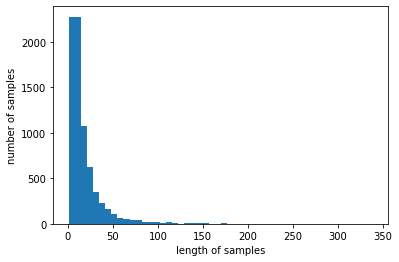

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

# check sentence length distribution
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 339이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 25내외의 길이를 가지는 것을 볼 수 있슴

모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있슴

특정 길이 변수를 max_len으로 정함

대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 얼마인지 확인하기 위해, 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듦

In [34]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 50

below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 94.19181757209925


전체 훈련 데이터 중 약 94%의 리뷰가 50이하의 길이를 가지는 것을 확인함 모든 샘플의 길이를 50으로 맞추어 보겠다.

In [36]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<center><h2><b>LSTM Modeling</b></h2></center>

In [39]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model/lnh_lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
94/94 [==============================] - 3s 18ms/step - loss: 0.5997 - acc: 0.6652 - val_loss: 0.5241 - val_acc: 0.7344

Epoch 00001: val_acc improved from -inf to 0.73441, saving model to ./model\lnh_lstm_model.h5
Epoch 2/15
94/94 [==============================] - 1s 10ms/step - loss: 0.4264 - acc: 0.8115 - val_loss: 0.4670 - val_acc: 0.7720

Epoch 00002: val_acc improved from 0.73441 to 0.77197, saving model to ./model\lnh_lstm_model.h5
Epoch 3/15
94/94 [==============================] - 1s 10ms/step - loss: 0.3552 - acc: 0.8421 - val_loss: 0.4770 - val_acc: 0.7646

Epoch 00003: val_acc did not improve from 0.77197
Epoch 4/15
94/94 [==============================] - 1s 10ms/step - loss: 0.3136 - acc: 0.8677 - val_loss: 0.4842 - val_acc: 0.7854

Epoch 00004: val_acc improved from 0.77197 to 0.78538, saving model to ./model\lnh_lstm_model.h5
Epoch 5/15
94/94 [==============================] - 1s 12ms/step - loss: 0.2861 - acc: 0.8825 - val_loss: 0.5779 - val_acc: 0.7451

Ep

In [41]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

59/59 [==============================] - 0s 4ms/step - loss: 0.5907 - acc: 0.7583

 테스트 정확도: 0.7583


<center><h2><b>Evaluation</b></h2></center>

In [44]:
def sentiment_predict(new_sentence):
    loaded_model = load_model('./model/lnh_lstm_model.h5')
    
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [47]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')
sentiment_predict('이 영화 핵노잼 ㅠㅠ')
sentiment_predict('이딴게 영화냐 ㅉㅉ')
sentiment_predict('감독 뭐하는 놈이냐?')
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

89.73% 확률로 긍정 리뷰입니다.

97.07% 확률로 부정 리뷰입니다.

96.69% 확률로 부정 리뷰입니다.

77.51% 확률로 부정 리뷰입니다.

66.25% 확률로 긍정 리뷰입니다.

